In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
import random
import pal5_util_MWfit
import MWPotential2014Likelihood
import os, os.path
import re
import glob
import pickle
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0






Populating the interactive namespace from numpy and matplotlib


Jo tested 32 different MW potential models by varying $(f_{d},f_{r},h_{R},h_{Z},r_{s})$. Ignore potential 14.
For each potential model, the MCMC chains have the following values : 
c,vo/220,dist/22.,pmo_parallel,pmo_perp, ln(sigv) and lnlike

In [2]:
def determine_nburn(filename='../pal5_mcmc/mwpot14-fitsigma-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        indx= (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)
        if maxln > -22.5:
            indx*= numpy.std(lndata,axis=1) < 3.
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[indx][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[indx][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100


nwalkers= 12

#from each MCMC chain file, pick nsamples
nsamples= 100


pot_ind=np.arange(0,32,1)
pot_ind=np.delete(pot_ind,14)

t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)

peri_all=[]


for pindx in pot_ind:
    
    print (pindx)
    # Load this potential
    fn= 'pal5_mcmc/mwpot14-fitsigma-%i.dat' % pindx
    with open(fn,'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':'.encode())[1].split(','.encode()))]
    #all_potparams[ii]= potparams
    
    tnburn= determine_nburn(fn)
    tdata= numpy.loadtxt(fn,comments='#',delimiter=',')
    tdata= tdata[tnburn::]
    
    rand_indx=random.sample(range(len(tdata)),nsamples)
    
    peri=[]
    c=1
    
    for jj in rand_indx:
        
        
        
        tvo= tdata[jj][1]*_REFV0
        pot= MWPotential2014Likelihood.setup_potential(potparams,tdata[jj][0],False,False,
                                                       pal5_util_MWfit._REFR0,tvo)

        # Now compute the stream model for this setup
        dist= tdata[jj][2]*22.
        pmra= -2.296+tdata[jj][3]+tdata[jj][4]
        pmdecpar= 2.257/2.296
        pmdecperp= -2.296/2.257
        pmdec= -2.257+tdata[jj][3]*pmdecpar+tdata[jj][4]*pmdecperp
        vlos= -58.7
        sigv= 0.4*numpy.exp(tdata[jj][5])
        prog= Orbit([229.018,-0.124,dist,pmra,pmdec,vlos],
                    radec=True,ro=ro,vo=tvo,
                    solarmotion=[-11.1,24.,7.25]).flip()
        
        prog.integrate(t_age,pot)
        peri.append(prog.rperi())
        
    peri_all.append(peri)
    

    

        
    

   
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


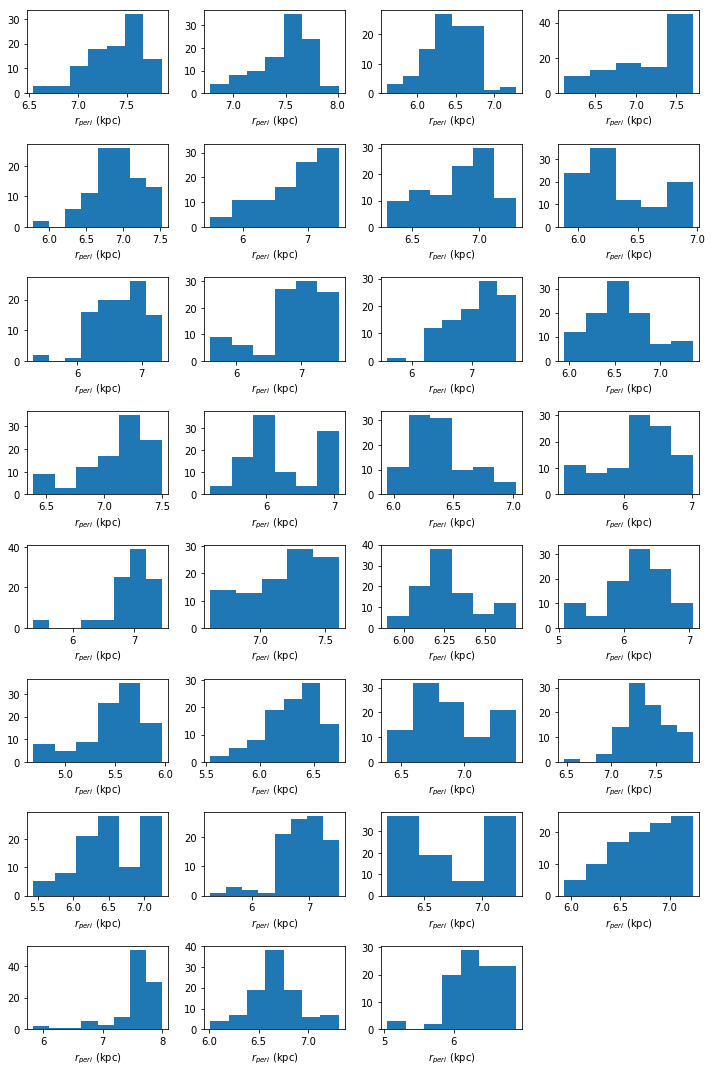

In [3]:
plt.figure(figsize=(10,15))

for ii in range(31):
    plt.subplot(8,4,ii+1)
    plt.hist(peri_all[ii],bins='scott')
    plt.xlabel(r'$r_{peri}$ (kpc)')
    
plt.tight_layout()
plt.show()